# Results of white-box MIAs on the Texas100 dataset

The models are trained using an MLP architecture referred to as MLP5 in the paper. 

The specification of this architecture is given in ```../configs/texas100/mlp_dropout.ini```.

We load results for MIAs trained using different features (specified below as ```activations``` or ```activations,gradients```), extracted from different layers (e.g., ```fc5``` which stands for the fifth fully connected layer). The features can be extracted from different types of shadow models, indicated in the ```attacker_accessess``` list below. We hope the naming to be self-explanatory. We refer you to ```shadow_modelling_attack.py``` for more details on the different types of shadow models. 

In [14]:
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import scipy.stats

In [15]:
attacker_accesses = ["aa-target_dataset",
    "aa-shadow_dataset_model_init",
    "aa-shadow_dataset",
    "aa-shadow_dataset-align-weight_sorting",
    "aa-shadow_dataset-align-bottom_up_weight_matching",
    "aa-shadow_dataset-align-top_down_weight_matching",
    "aa-shadow_dataset-align-top_down_activation_matching",
    "aa-shadow_dataset-align-bottom_up_correlation_matching",
    "aa-shadow_dataset-set-based"
]

In [16]:
roc_results = {attacker_access: 
               {f : defaultdict(list) 
                for f in ['activations', 'activations,gradients']} 
               for attacker_access in attacker_accesses}

In [17]:
experiments_dir = '../experiments/texas100/attack/generic-mlp-dropout_6169,1024,512,256,128,100/attack_results'
num_repetitions = 10

for features in ['activations']:
    print(f'\nFeatures: {features} \n')
    target_layers = ["fc5", "fc5-ia"]
    for attacker_access in attacker_accesses:
        print(f'\nAttacker access: {attacker_access}')
        results = {layer: {"test_acc": [], "test_auc": [], "best_test_acc": [], "val_auc": []} for layer in target_layers}

        for layer in target_layers:
            num_repetitions_found = 0
            for exp in range(num_repetitions):
                result_dir = os.path.join(experiments_dir, attacker_access, features, layer)
                saved_model_path = os.path.join(result_dir, f'exp_{exp}_model.pickle')
                if not os.path.exists(saved_model_path):
                    continue
                with open(saved_model_path, 'rb') as f:
                    saved_model = pickle.load(f)
                    if not saved_model['train_complete']:
                        continue
                    test_metrics = saved_model['test_metrics']
                test_acc = test_metrics['best_acc']
                test_auc = test_metrics['auc']
                results[layer]['test_auc'].append(test_auc)
                results[layer]['val_auc'].append(saved_model['val_metrics']['auc'])
                results[layer]['test_acc'].append(test_acc)
                roc_results[attacker_access][features][layer].append( 
                    (test_metrics['fpr'], test_metrics['tpr']) )
                num_repetitions_found += 1
            if num_repetitions_found == 0:
                continue
            mean_test_auc, std_test_auc = np.mean(results[layer]['test_auc']), np.std(results[layer]['test_auc'])
            mean_test_acc, std_test_acc = np.mean(results[layer]['test_acc']), np.std(results[layer]['test_acc'])
            h_test_auc =  std_test_auc * scipy.stats.t.ppf((1 + 0.95) / 2., num_repetitions_found-1) / (num_repetitions_found**0.5)
            print(f'Layer {layer}: {num_repetitions_found} experiments. ', 
                f'Test auc {mean_test_auc:.3f} ({h_test_auc:.3f}), best test acc: {mean_test_acc:.1%} ({std_test_acc:.1%})')
    
            mean_test_auc, std_test_auc = np.mean(results[layer]['val_auc']), np.std(results[layer]['val_auc'])
            print(f'Val auc {mean_test_auc:.3f} ({std_test_auc:.3f})')


Features: activations 


Attacker access: aa-target_dataset
Layer fc5: 10 experiments.  Test auc 0.880 (0.015), best test acc: 80.7% (2.2%)
Val auc 0.876 (0.024)
Layer fc5-ia: 10 experiments.  Test auc 0.907 (0.019), best test acc: 83.0% (2.8%)
Val auc 0.904 (0.029)

Attacker access: aa-shadow_dataset_model_init
Layer fc5: 10 experiments.  Test auc 0.843 (0.023), best test acc: 75.6% (4.8%)
Val auc 0.855 (0.016)
Layer fc5-ia: 10 experiments.  Test auc 0.836 (0.022), best test acc: 74.0% (4.3%)
Val auc 0.857 (0.011)

Attacker access: aa-shadow_dataset
Layer fc5: 10 experiments.  Test auc 0.859 (0.015), best test acc: 77.8% (3.0%)
Val auc 0.859 (0.003)
Layer fc5-ia: 10 experiments.  Test auc 0.815 (0.015), best test acc: 72.5% (1.6%)
Val auc 0.828 (0.006)

Attacker access: aa-shadow_dataset-align-weight_sorting

Attacker access: aa-shadow_dataset-align-bottom_up_weight_matching

Attacker access: aa-shadow_dataset-align-top_down_weight_matching

Attacker access: aa-shadow_dataset-align-t

In [18]:
features = 'activations,gradients'
print(f'\nFeatures: {features} \n')

target_layers = ["fc5-ia", "fc5", "fc5-ia,fc4"]

for attacker_access in attacker_accesses:
    print(f'\nAttacker access: {attacker_access}')
    results = {layer: {"test_acc": [], "test_auc": [], "best_test_acc": []} for layer in target_layers}

    for layer in target_layers:
        num_repetitions_found = 0
        for exp in range(num_repetitions):
            result_dir = os.path.join(experiments_dir, attacker_access, features, layer)
            saved_model_path = os.path.join(result_dir, f'exp_{exp}_model.pickle')
            if not os.path.exists(saved_model_path):
                continue
            with open(saved_model_path, 'rb') as f:
                saved_model = pickle.load(f)
                if not saved_model['train_complete']:
                    continue
                test_metrics = saved_model['test_metrics']
            test_acc = test_metrics['best_acc']
            test_auc = test_metrics['auc']
            results[layer]['test_auc'].append(test_auc)
            results[layer]['test_acc'].append(test_acc)
            roc_results[attacker_access][features][layer].append( 
                (test_metrics['fpr'], test_metrics['tpr']) )
            num_repetitions_found += 1
        if num_repetitions_found == 0:
            continue
        mean_test_auc, std_test_auc = np.mean(results[layer]['test_auc']), np.std(results[layer]['test_auc'])
        mean_test_acc, std_test_acc = np.mean(results[layer]['test_acc']), np.std(results[layer]['test_acc'])
        h_test_auc =  std_test_auc * scipy.stats.t.ppf((1 + 0.95) / 2., num_repetitions_found-1) / (num_repetitions_found**0.5)
        print(f'Layer {layer}: {num_repetitions_found} experiments. ', 
            f'Test auc {mean_test_auc:.3f} ({h_test_auc:.3f}), best test acc: {mean_test_acc:.1%} ({std_test_acc:.1%})')


Features: activations,gradients 


Attacker access: aa-target_dataset
Layer fc5-ia: 10 experiments.  Test auc 0.912 (0.020), best test acc: 83.8% (3.0%)
Layer fc5: 10 experiments.  Test auc 0.904 (0.021), best test acc: 83.1% (3.3%)

Attacker access: aa-shadow_dataset_model_init
Layer fc5-ia: 10 experiments.  Test auc 0.873 (0.041), best test acc: 77.2% (9.2%)
Layer fc5: 10 experiments.  Test auc 0.862 (0.063), best test acc: 77.1% (11.1%)

Attacker access: aa-shadow_dataset
Layer fc5-ia: 10 experiments.  Test auc 0.857 (0.048), best test acc: 76.7% (8.6%)
Layer fc5: 10 experiments.  Test auc 0.862 (0.065), best test acc: 77.8% (11.1%)

Attacker access: aa-shadow_dataset-align-weight_sorting
Layer fc5-ia: 10 experiments.  Test auc 0.866 (0.041), best test acc: 77.4% (8.0%)
Layer fc5: 10 experiments.  Test auc 0.862 (0.067), best test acc: 77.2% (11.1%)

Attacker access: aa-shadow_dataset-align-bottom_up_weight_matching
Layer fc5-ia: 10 experiments.  Test auc 0.878 (0.039), best test a

# ROC curve

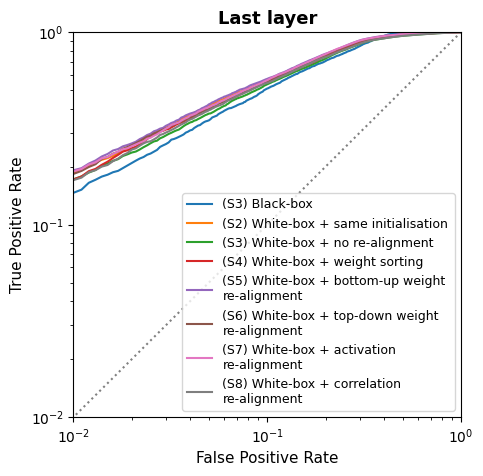

In [19]:
from confidence_interval import ci_roc_curve

white_box_layers, title = ('fc5-ia', 'Last layer')

attacks = [('aa-shadow_dataset', 'activations', 'fc5', 
            '(S3) Black-box'),
        ('aa-shadow_dataset_model_init', 'activations,gradients', white_box_layers, 
         '(S2) White-box + same initialisation'),
        ('aa-shadow_dataset', 'activations,gradients', white_box_layers, 
         '(S3) White-box + no re-alignment'),
        ('aa-shadow_dataset-align-weight_sorting', 'activations,gradients', white_box_layers, 
         '(S4) White-box + weight sorting'),
        ('aa-shadow_dataset-align-bottom_up_weight_matching', 'activations,gradients', white_box_layers, 
         '(S5) White-box + bottom-up weight \nre-alignment'),
        ('aa-shadow_dataset-align-top_down_weight_matching', 'activations,gradients', white_box_layers, 
         '(S6) White-box + top-down weight \nre-alignment'),
        ('aa-shadow_dataset-align-top_down_activation_matching', 'activations,gradients', white_box_layers, 
         '(S7) White-box + activation \nre-alignment'),
        ('aa-shadow_dataset-align-bottom_up_correlation_matching', 'activations,gradients', white_box_layers, 
         '(S8) White-box + correlation \nre-alignment')]
base_fpr = np.linspace(0, 1, 1001)

fig, ax = plt.subplots(figsize=(5, 5))

for attack in attacks:
    attacker_access, features, layers, label = attack
    fprs, tprs = zip(*roc_results[attacker_access][features][layers])
    mean_tpr, lower_tpr, upper_tpr = ci_roc_curve(fprs, tprs, base_fpr)
    ax.plot(base_fpr, mean_tpr, label=label)

ax.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), color='gray', ls=':')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(1e-2, 1)
ax.set_ylim(1e-2, 1)
ax.set_xlabel('False Positive Rate', fontsize=11)
ax.set_ylabel('True Positive Rate', fontsize=11)
ax.legend(fontsize=9, loc='lower right')
plt.title(title, fontweight='bold', fontsize=13)
plt.savefig(f'../notebooks/plots/roc_texas100_{white_box_layers}.pdf', bbox_inches='tight')
plt.show()
plt.close()